Creating taxonomic profile matrix...
Matrix shape: (10, 47)
Performing PCA analysis...


/tmp/ipykernel_2532861/1147965789.py:95: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  profile_matrix = profile_matrix.fillna(0)  # Fill with zeros initially
/tmp/ipykernel_2532861/1147965789.py:104: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '88.01' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  profile_matrix.loc[sample, taxon] = abundance
/tmp/ipykernel_2532861/1147965789.py:104: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.12' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  profile_matrix.loc[sample, taxon] = abundan

Performing hierarchical clustering...
Identifying discriminating taxa...
Top discriminating taxa:
                         Group1_Mean  Group2_Mean  Absolute_Difference  \
G_Betacoronavirus             69.892        0.000               69.892   
G_Bacteroides                  0.000       12.678               12.678   
G_Prevotella                   0.000       12.290               12.290   
G_Phocaeicola                  0.000        8.028                8.028   
G_Faecalibacterium             0.000        3.758                3.758   
G_Parabacteroides              0.000        3.474                3.474   
G_Alistipes                    0.000        2.162                2.162   
G_Phascolarctobacterium        0.000        1.692                1.692   
G_Staphylococcus               1.358        0.000                1.358   
G_Enterobacter                 0.000        1.062                1.062   
G_Carjivirus                   0.000        0.842                0.842   
G_Vescimonas  

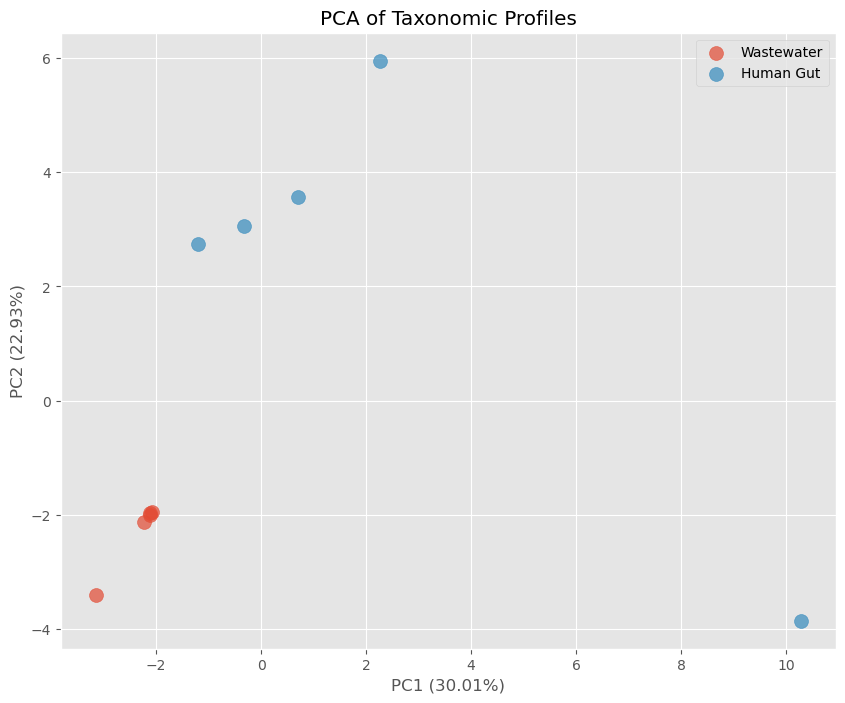

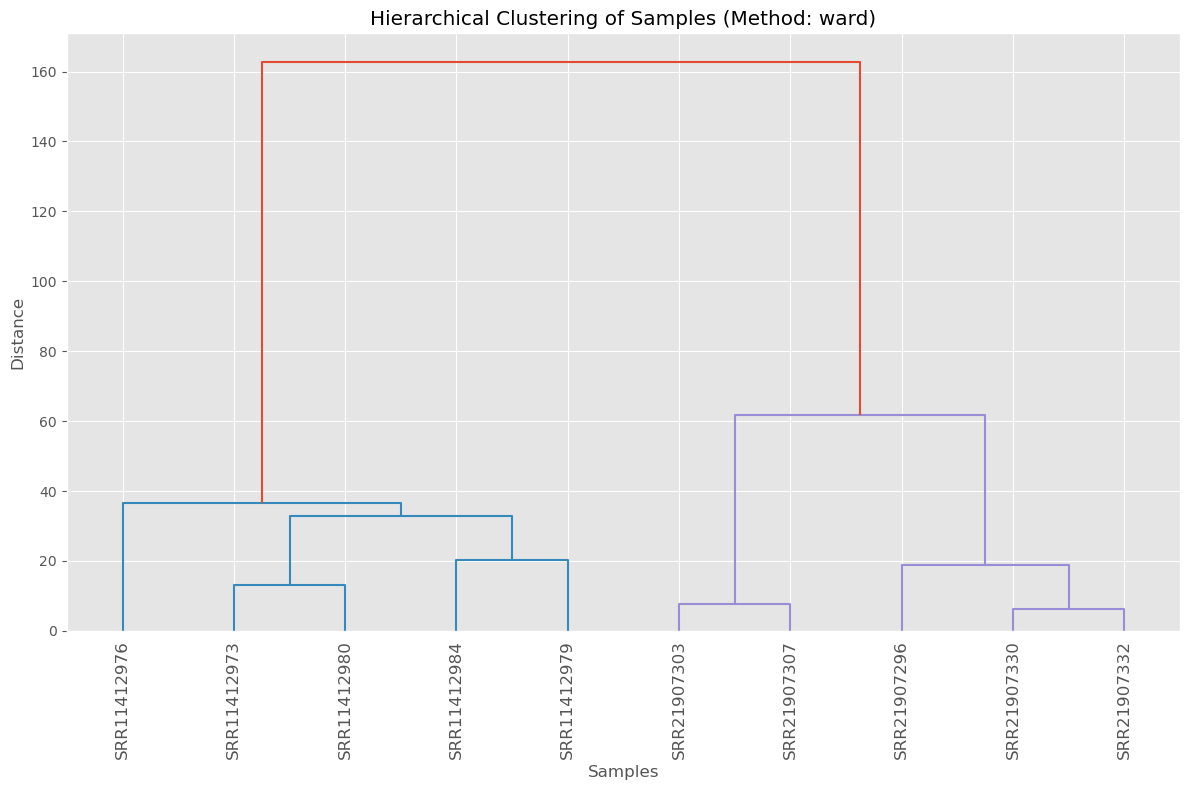

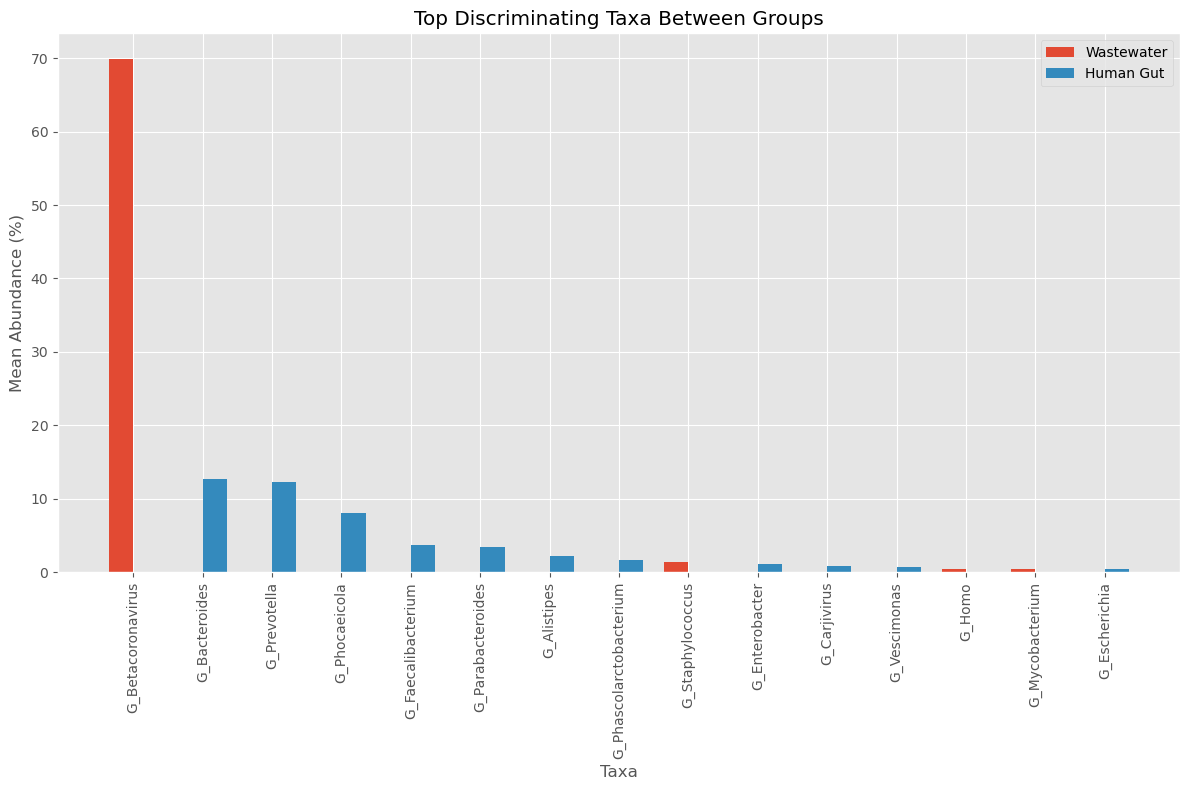

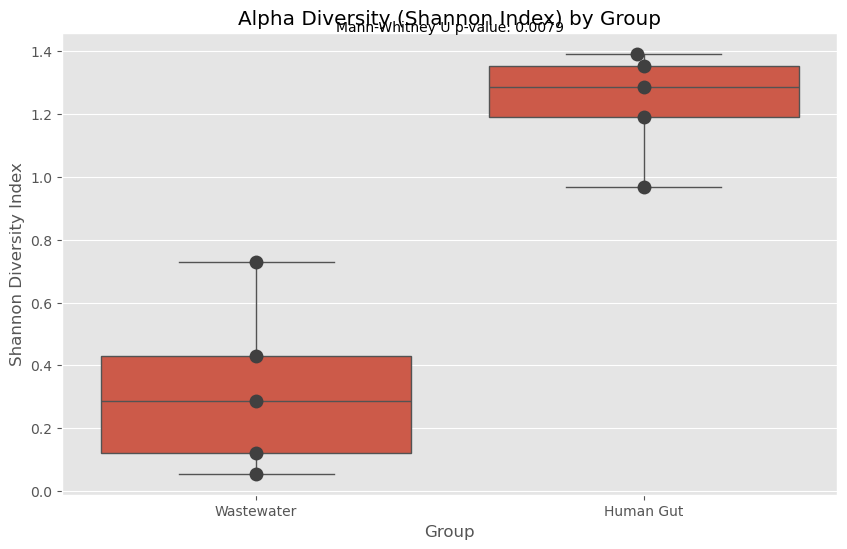

<Figure size 1400x1000 with 0 Axes>

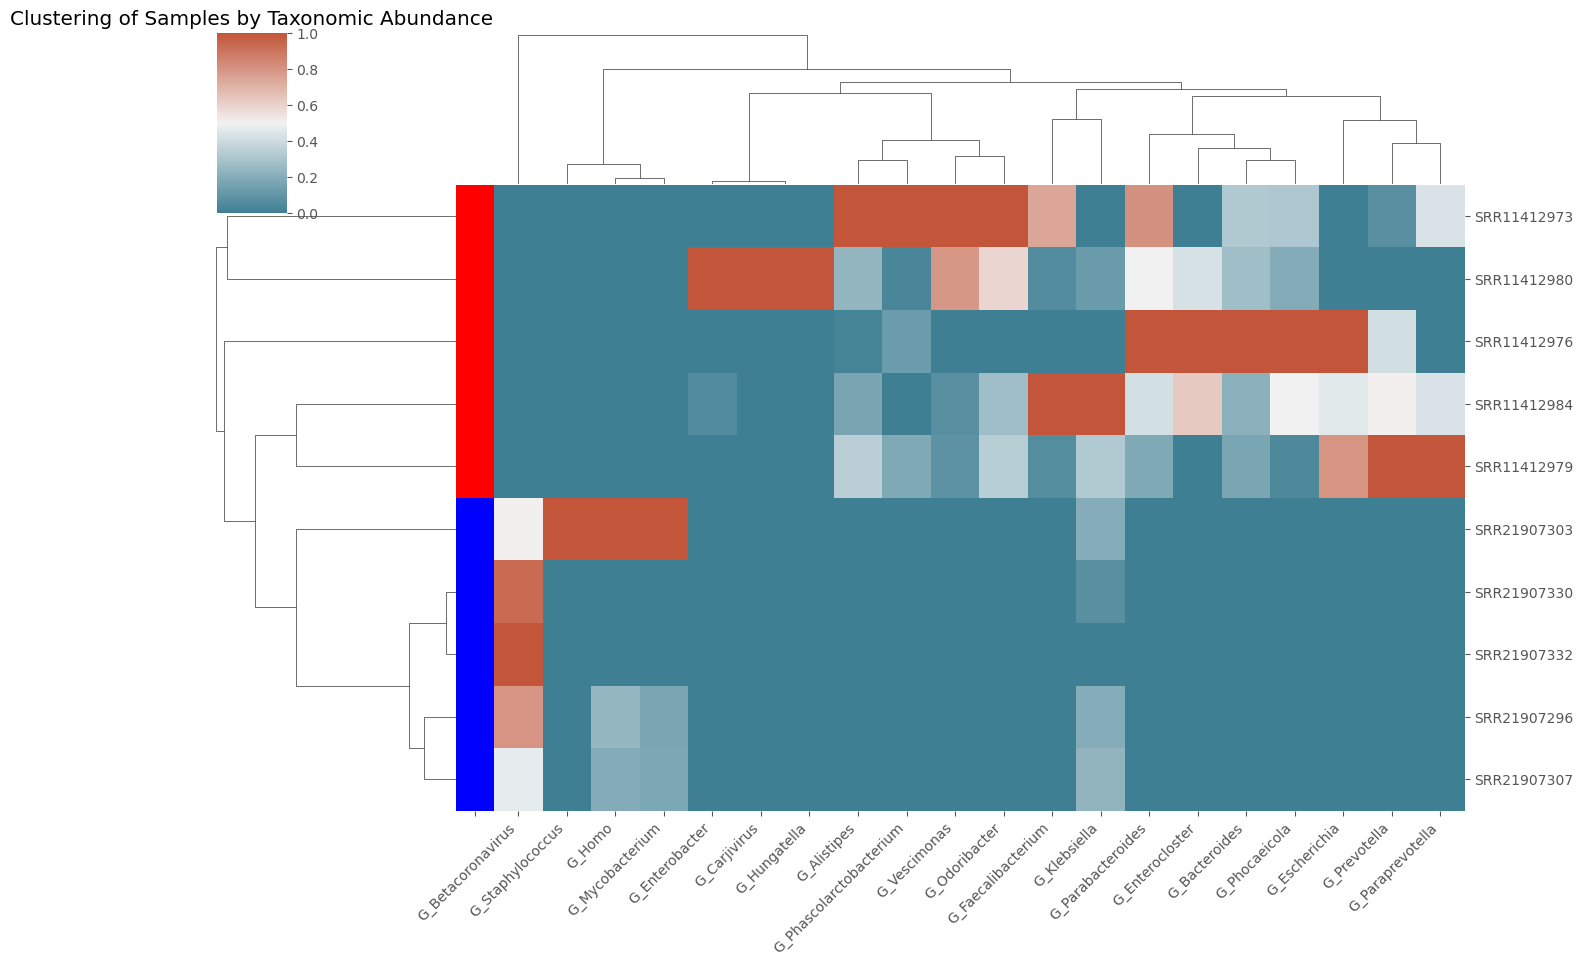

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import pdist, squareform
from scipy.stats import mannwhitneyu
import re

# Set up matplotlib parameters for better visualizations
plt.rcParams['figure.figsize'] = (12, 8)
plt.style.use('ggplot')

# Define the path to the results directory
results_dir = "metagenomic_analysis/results"

# Function to parse Kraken2 report files
def parse_kraken_report(file_path, min_abundance=0.01, taxonomic_level=None):
    """
    Parse a Kraken2 report file and extract taxonomic information.
    
    Parameters:
    file_path (str): Path to the Kraken2 report file
    min_abundance (float): Minimum abundance percentage to include
    taxonomic_level (str, optional): Filter by taxonomic level (G for genus, F for family, etc.)
    
    Returns:
    dict: Dictionary with taxon names as keys and abundance percentages as values
    """
    taxa_dict = {}
    
    with open(file_path, 'r') as f:
        for line in f:
            parts = line.strip().split('\t')
            if len(parts) < 6:
                continue
            
            percentage = float(parts[0])
            # Skip taxa with abundance below threshold
            if percentage < min_abundance:
                continue
                
            rank_code = parts[3]
            taxon_id = parts[4]
            taxon_name = parts[5].strip()
            
            # Remove leading spaces and taxonomic prefixes for clarity
            taxon_name = re.sub(r'^\s+[A-Z]\s+', '', taxon_name)
            taxon_name = re.sub(r'^\s+', '', taxon_name)
            
            # Filter by taxonomic level if specified
            if taxonomic_level and rank_code != taxonomic_level:
                continue
                
            # Handle unclassified reads separately
            if taxon_id == '0' and "unclassified" in taxon_name.lower():
                taxa_dict["Unclassified"] = percentage
            elif rank_code in ['G', 'F', 'O', 'C', 'P', 'D', 'S']:  # Include genus, family, order, class, phylum, domain, species
                taxa_dict[f"{rank_code}_{taxon_name}"] = percentage
    
    return taxa_dict

# Function to create a taxonomic profile matrix from all samples
def create_taxonomic_profile_matrix(results_dir, taxonomic_level=None, min_abundance=0.01):
    """
    Create a matrix of taxonomic profiles from all samples.
    
    Parameters:
    results_dir (str): Directory containing result folders for each sample
    taxonomic_level (str, optional): Filter by taxonomic level
    min_abundance (float): Minimum abundance percentage to include
    
    Returns:
    pd.DataFrame: Matrix with samples as rows and taxa as columns
    """
    # Get a list of sample directories
    sample_dirs = [d for d in os.listdir(results_dir) if os.path.isdir(os.path.join(results_dir, d))]
    
    # Initialize dictionary to hold all taxa from all samples
    all_taxa = {}
    
    # First pass: collect all taxa across all samples
    for sample in sample_dirs:
        report_file = os.path.join(results_dir, sample, "kraken2_report.txt")
        if os.path.exists(report_file):
            taxa_dict = parse_kraken_report(report_file, min_abundance, taxonomic_level)
            for taxon in taxa_dict.keys():
                all_taxa[taxon] = 0  # Just initialize with zero
    
    # Create the matrix with all samples and all taxa
    profile_matrix = pd.DataFrame(index=sample_dirs, columns=list(all_taxa.keys()))
    profile_matrix = profile_matrix.fillna(0)  # Fill with zeros initially
    
    # Second pass: fill in the matrix with actual values
    for sample in sample_dirs:
        report_file = os.path.join(results_dir, sample, "kraken2_report.txt")
        if os.path.exists(report_file):
            taxa_dict = parse_kraken_report(report_file, min_abundance, taxonomic_level)
            for taxon, abundance in taxa_dict.items():
                if taxon in profile_matrix.columns:
                    profile_matrix.loc[sample, taxon] = abundance
    
    return profile_matrix

# Function to plot PCA of taxonomic profiles
def plot_pca(profile_matrix, groups=None):
    """
    Perform PCA on the taxonomic profiles and plot the results.
    
    Parameters:
    profile_matrix (pd.DataFrame): Matrix with samples as rows and taxa as columns
    groups (dict, optional): Dictionary mapping sample ids to group labels
    
    Returns:
    tuple: (pca_model, pca_result_df) containing the PCA model and transformed data
    """
    # Standardize the data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(profile_matrix)
    
    # Apply PCA
    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(scaled_data)
    
    # Create DataFrame with PCA results
    pca_result_df = pd.DataFrame(data=principal_components, 
                                 columns=['PC1', 'PC2'], 
                                 index=profile_matrix.index)
    
    # Add group information if provided
    if groups:
        pca_result_df['Group'] = pca_result_df.index.map(groups)
    
    # Create PCA plot
    plt.figure(figsize=(10, 8))
    
    if groups:
        # Plot with group colors
        for group_name in set(groups.values()):
            group_data = pca_result_df[pca_result_df['Group'] == group_name]
            plt.scatter(group_data['PC1'], group_data['PC2'], label=group_name, s=100, alpha=0.7)
        plt.legend()
    else:
        # Simple plot without groups
        plt.scatter(pca_result_df['PC1'], pca_result_df['PC2'], s=100, alpha=0.7)
        for i, sample_id in enumerate(profile_matrix.index):
            plt.annotate(sample_id, (principal_components[i, 0], principal_components[i, 1]))
    
    # Add explanatory text
    explained_variance = pca.explained_variance_ratio_ * 100
    plt.xlabel(f'PC1 ({explained_variance[0]:.2f}%)')
    plt.ylabel(f'PC2 ({explained_variance[1]:.2f}%)')
    plt.title('PCA of Taxonomic Profiles')
    plt.grid(True)
    
    return pca, pca_result_df

# Function to perform hierarchical clustering
def perform_hierarchical_clustering(profile_matrix, method='ward'):
    """
    Perform hierarchical clustering on the taxonomic profiles and plot a dendrogram.
    
    Parameters:
    profile_matrix (pd.DataFrame): Matrix with samples as rows and taxa as columns
    method (str): Linkage method to use
    
    Returns:
    numpy.ndarray: The hierarchical clustering encoded as a linkage matrix
    """
    # Calculate distance matrix
    dist_matrix = pdist(profile_matrix.values, metric='euclidean')
    
    # Perform hierarchical clustering
    Z = linkage(dist_matrix, method=method)
    
    # Plot dendrogram
    plt.figure(figsize=(12, 8))
    dendrogram(Z, labels=profile_matrix.index, leaf_rotation=90)
    plt.title(f'Hierarchical Clustering of Samples (Method: {method})')
    plt.xlabel('Samples')
    plt.ylabel('Distance')
    plt.tight_layout()
    
    return Z

# Function to identify discriminating taxa between groups
def identify_discriminating_taxa(profile_matrix, groups, top_n=10):
    """
    Identify taxa that best discriminate between two groups.
    
    Parameters:
    profile_matrix (pd.DataFrame): Matrix with samples as rows and taxa as columns
    groups (dict): Dictionary mapping sample ids to group labels
    top_n (int): Number of top discriminating taxa to return
    
    Returns:
    pd.DataFrame: DataFrame with taxa and their discrimination scores
    """
    # Add group column to the profile matrix
    profile_with_groups = profile_matrix.copy()
    profile_with_groups['Group'] = profile_with_groups.index.map(groups)
    
    # Get unique group names
    group_names = list(set(groups.values()))
    if len(group_names) != 2:
        raise ValueError("This function requires exactly two groups.")
    
    # Calculate mean abundance for each taxon in each group
    group1_data = profile_with_groups[profile_with_groups['Group'] == group_names[0]].drop('Group', axis=1)
    group2_data = profile_with_groups[profile_with_groups['Group'] == group_names[1]].drop('Group', axis=1)
    
    group1_means = group1_data.mean()
    group2_means = group2_data.mean()
    
    # Calculate absolute difference in means
    diff_means = abs(group1_means - group2_means)
    
    # Calculate statistical significance
    p_values = {}
    for taxon in profile_matrix.columns:
        _, p_value = mannwhitneyu(group1_data[taxon], group2_data[taxon], alternative='two-sided')
        p_values[taxon] = p_value
    
    # Create DataFrame with results
    results = pd.DataFrame({
        'Group1_Mean': group1_means,
        'Group2_Mean': group2_means,
        'Absolute_Difference': diff_means,
        'P_Value': pd.Series(p_values)
    })
    
    # Sort by absolute difference and get top N taxa
    top_taxa = results.sort_values('Absolute_Difference', ascending=False).head(top_n)
    
    # Create bar plot of top discriminating taxa
    plt.figure(figsize=(12, 8))
    
    # Set up plot for mean values
    x = np.arange(len(top_taxa))
    width = 0.35
    
    plt.bar(x - width/2, top_taxa['Group1_Mean'], width, label=group_names[0])
    plt.bar(x + width/2, top_taxa['Group2_Mean'], width, label=group_names[1])
    
    plt.xlabel('Taxa')
    plt.ylabel('Mean Abundance (%)')
    plt.title('Top Discriminating Taxa Between Groups')
    plt.xticks(x, top_taxa.index, rotation=90)
    plt.legend()
    plt.tight_layout()
    
    return top_taxa

# Function to calculate alpha diversity (Shannon index)
def calculate_alpha_diversity(profile_matrix, groups=None):
    """
    Calculate Shannon diversity index for each sample.
    
    Parameters:
    profile_matrix (pd.DataFrame): Matrix with samples as rows and taxa as columns
    groups (dict, optional): Dictionary mapping sample ids to group labels
    
    Returns:
    pd.DataFrame: DataFrame with Shannon diversity for each sample
    """
    # Shannon index calculation
    shannon_diversity = []
    
    for idx, row in profile_matrix.iterrows():
        # Filter out zero values and convert to proportions
        abundances = row[row > 0] / 100.0  # Convert percentage to proportion
        
        # Calculate Shannon index: -sum(p_i * log(p_i))
        diversity = -np.sum(abundances * np.log(abundances))
        shannon_diversity.append(diversity)
    
    # Create DataFrame with results
    diversity_df = pd.DataFrame({
        'Sample': profile_matrix.index,
        'Shannon_Diversity': shannon_diversity
    })
    
    # Add group information if provided
    if groups:
        diversity_df['Group'] = diversity_df['Sample'].map(groups)
        
        # Create a boxplot of diversity by group
        plt.figure(figsize=(10, 6))
        sns.boxplot(x='Group', y='Shannon_Diversity', data=diversity_df)
        plt.title('Alpha Diversity (Shannon Index) by Group')
        plt.xlabel('Group')
        plt.ylabel('Shannon Diversity Index')
        
        # Add individual points
        sns.swarmplot(x='Group', y='Shannon_Diversity', data=diversity_df, color='.25', size=10)
        
        # Perform statistical test between groups
        group_names = list(set(groups.values()))
        if len(group_names) == 2:
            group1_div = diversity_df[diversity_df['Group'] == group_names[0]]['Shannon_Diversity']
            group2_div = diversity_df[diversity_df['Group'] == group_names[1]]['Shannon_Diversity']
            _, p_value = mannwhitneyu(group1_div, group2_div, alternative='two-sided')
            plt.text(0.5, max(shannon_diversity)*1.05, f'Mann-Whitney U p-value: {p_value:.4f}', 
                    horizontalalignment='center')
    
    return diversity_df

# Main analysis workflow
def main():
    # 1. Create taxonomic profile matrix (using genus level for clarity)
    print("Creating taxonomic profile matrix...")
    genus_profiles = create_taxonomic_profile_matrix(results_dir, taxonomic_level='G', min_abundance=0.1)
    print(f"Matrix shape: {genus_profiles.shape}")
    
    # Check if we have enough data
    if genus_profiles.shape[0] < 2:
        print("Not enough samples found. Please check the results directory.")
        return
    
    # Define sample grouping - Gut (SRR11412*) vs Wastewater (SRR21907*)
    sample_groups = {}
    for sample_id in genus_profiles.index:
        if sample_id.startswith('SRR11412'):
            sample_groups[sample_id] = 'Human Gut'
        elif sample_id.startswith('SRR21907'):
            sample_groups[sample_id] = 'Wastewater'
        else:
            sample_groups[sample_id] = 'Unknown'
    
    # 2. Perform PCA analysis
    print("Performing PCA analysis...")
    pca_model, pca_result = plot_pca(genus_profiles, sample_groups)
    plt.savefig('pca_analysis.png', dpi=300, bbox_inches='tight')
    
    # 3. Perform hierarchical clustering
    print("Performing hierarchical clustering...")
    cluster_linkage = perform_hierarchical_clustering(genus_profiles)
    plt.savefig('hierarchical_clustering.png', dpi=300, bbox_inches='tight')
    
    # 4. Identify discriminating taxa between groups
    print("Identifying discriminating taxa...")
    try:
        top_taxa = identify_discriminating_taxa(genus_profiles, sample_groups, top_n=15)
        plt.savefig('discriminating_taxa.png', dpi=300, bbox_inches='tight')
        print("Top discriminating taxa:")
        print(top_taxa)
    except ValueError as e:
        print(f"Error identifying discriminating taxa: {e}")
    
    # 5. Calculate alpha diversity
    print("\nCalculating alpha diversity...")
    diversity_results = calculate_alpha_diversity(genus_profiles, sample_groups)
    plt.savefig('alpha_diversity.png', dpi=300, bbox_inches='tight')
    
    # 6. Create heatmap of top taxa
    print("Creating abundance heatmap...")
    plt.figure(figsize=(14, 10))
    
    # Get top 20 most abundant taxa across all samples
    most_abundant = genus_profiles.mean().sort_values(ascending=False).head(20).index
    
    # Create a heatmap of these taxa
    heatmap_data = genus_profiles[most_abundant].copy()
    
    # Add group information for color bar
    group_colors = pd.Series(sample_groups).map({'Human Gut': 'red', 'Wastewater': 'blue'})
    
    # Create the heatmap
    cmap = sns.diverging_palette(220, 20, as_cmap=True)
    g = sns.clustermap(
        heatmap_data,
        cmap=cmap,
        standard_scale=1,  # Scale data across rows
        figsize=(14, 10),
        row_colors=group_colors,
        col_cluster=True,
        row_cluster=True,
        xticklabels=1,
        yticklabels=1
    )
    
    # Adjust labels
    plt.setp(g.ax_heatmap.get_xticklabels(), rotation=45, ha='right')
    plt.title('Clustering of Samples by Taxonomic Abundance')
    plt.savefig('abundance_heatmap.png', dpi=300, bbox_inches='tight')
    
    # 7. Assess clustering accuracy
    print("\nAssessing whether samples cluster by environment...")
    
    # Determine if PCA separates the samples by group
    pca_result['x_pos'] = pca_result['PC1'] > 0
    pca_result['y_pos'] = pca_result['PC2'] > 0
    
    # Count how many samples from each group fall in each quadrant
    quadrant_counts = {}
    for group in set(sample_groups.values()):
        group_data = pca_result[pca_result['Group'] == group]
        quadrant_counts[group] = {
            'Q1 (++)': sum((group_data['x_pos']) & (group_data['y_pos'])),
            'Q2 (-+)': sum((~group_data['x_pos']) & (group_data['y_pos'])),
            'Q3 (--)': sum((~group_data['x_pos']) & (~group_data['y_pos'])),
            'Q4 (+-)': sum((group_data['x_pos']) & (~group_data['y_pos']))
        }
    
    quadrant_df = pd.DataFrame(quadrant_counts).T
    print("\nSample distribution by PCA quadrant:")
    print(quadrant_df)
    
    # Check if samples from the same environment tend to cluster together
    same_group_count = 0
    for i, sample1 in enumerate(list(genus_profiles.index)[:-1]):
        for sample2 in list(genus_profiles.index)[i+1:]:
            # Check if both samples are from the same group
            if sample_groups[sample1] == sample_groups[sample2]:
                same_group_count += 1
                
    total_pairs = len(genus_profiles) * (len(genus_profiles) - 1) // 2
    print(f"\nProportion of sample pairs from the same environment: {same_group_count/total_pairs:.2%}")
    
    # Generate a summary of the analysis results
    print("\n==== SUMMARY OF METAGENOMIC ANALYSIS ====")
    print(f"Total samples analyzed: {len(genus_profiles)}")
    print(f"Number of taxa identified: {len(genus_profiles.columns)}")
    
    # Count samples by group
    group_counts = {}
    for group in sample_groups.values():
        if group not in group_counts:
            group_counts[group] = 0
        group_counts[group] += 1
    
    print("\nSamples by environment:")
    for group, count in group_counts.items():
        print(f"- {group}: {count} samples")
    
    print("\nAnalysis results:")
    print("1. PCA visualization saved to 'pca_analysis.png'")
    print("2. Hierarchical clustering saved to 'hierarchical_clustering.png'")
    print("3. Discriminating taxa analysis saved to 'discriminating_taxa.png'")
    print("4. Alpha diversity analysis saved to 'alpha_diversity.png'")
    print("5. Abundance heatmap saved to 'abundance_heatmap.png'")
    
    print("\nConclusion:")
    # Check if the top principal component explains a significant portion of variance
    if pca_model.explained_variance_ratio_[0] > 0.3:
        print(f"The first principal component explains {pca_model.explained_variance_ratio_[0]:.1%} of variance,")
        print("suggesting a strong pattern in the data.")
    
    # Make a determination based on the PCA and clustering results
    group_pc1_means = pca_result.groupby('Group')['PC1'].mean()
    group_pc2_means = pca_result.groupby('Group')['PC2'].mean()
    
    pc1_diff = abs(group_pc1_means.iloc[0] - group_pc1_means.iloc[1])
    pc2_diff = abs(group_pc2_means.iloc[0] - group_pc2_means.iloc[1])
    
    if pc1_diff > 2 or pc2_diff > 2:
        print("The analysis shows clear separation between environmental sources,")
        print("confirming that human gut and wastewater samples have distinct microbial profiles.")
    else:
        print("The separation between environmental sources is present but not strong,")
        print("suggesting some overlap in the microbial communities of these environments.")
    
    # Return the key result dataframes
    return {
        'profiles': genus_profiles,
        'pca_results': pca_result,
        'diversity': diversity_results,
        'discriminating_taxa': top_taxa if 'top_taxa' in locals() else None
    }

# Run the main analysis
if __name__ == "__main__":
    results = main()